# Recitation 9: Benders decomposition for stochastic facility location

In [ ]:
!python -m pip install -U notebook-as-pdf
!pyppeteer-install

In [1]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots
using Suppressor
using Distributions
using Distances

const GRB_ENV = Gurobi.Env(output_flag = 0)

Gurobi.Env(Ptr{Nothing} @0x00000002acbb5600, false, 0)

## 1. Problem setup

We consider $n$ candidate facilities, indexed by $j=1,\cdots,n$, and $m$ customers, indexed by $i=1,\cdots,m$. We have data on transportation costs $t_{ij}$, shortage costs $u_i$, and facility construction costs $c_j$, and facility capacities $C_j$. Customer demand is stochastic. We characterize it via a set of $S$ scenarios, indexed by $s=1,\cdots,S$ and each assoiated with a probability $p_s$. The demand from customer $i$ in scenario $s$ is denoted by $d_{is}$.

We want to solve the following stochastic facility location problem:
$$
\begin{align}
    \min \quad 
    & \sum_{j=1}^n c_j x_j
    + \sum_{s=1}^S p_s \cdot \left(
        \sum_{j=1}^n \sum_{i=1}^m t _{ij} y_{ij}^s 
        + \sum_{i=1}^m u_i z_{i}^s
    \right)
    \\ 
    \text{s.t.} \quad 
    & \left( \sum_{j=1}^n y_{ij}^s \right) 
    + z_i^s \geq d_i^s 
    && \forall \ i \in [m], \ s \in [S]
    \\
    & \sum_{i=1}^m y_{ij}^s \leq C_j x_j 
    && \forall \ j \in [n], \ s \in [S]
    \\
    & \mathbf{y}, \mathbf{z} \geq 0, 
    \ \mathbf{x} \in \{0,1\}^n
\end{align}
$$

where:
$$
\begin{aligned}
    x_j & = \begin{cases}
        1 & \text{if facility $j$ is built} \\
        0 & \text{otherwise}
    \end{cases}
    \\
    y_{ij}^s & = \text{quantity transported from facility $j$ to customer $i$ in scenario $s$}
    \\
    z_{i}^s&=\text{unmet demand from customer $i$ in scenario $s$}
\end{aligned}
$$

## 2. Data Setup

We need to define quite a bit of data, so we're going to need to think a little more carefully than usual about how to store the data and parameters. First, we can use a NamedTuple to keep track of parameters.

In [6]:
function create_parameters(n, m, S)
    parameters = (
        seed = 3000,
        num_facilities = n,
        num_customers = m,
        num_scenarios = S,
        square_size = 10, # km
        unit_cost_per_km = 0.05,
        
        # demand generation
        demand_base_shape = 300,
        demand_base_scale = 4,
        demand_mult_shape = 4,
        demand_mult_scale = .25,
        
        # cost of unmet demand
        min_unmet_cost = 0.0, 
        max_unmet_cost = 20.0,
        
        # cost of facility
        f_shape = 8,
        f_scale = .125,
        
        # capacity at each facility
        cap_shape = 3,
        cap_scale = 50,
    )
    return parameters
end

# All dimensions assumed to be self-consistent
struct FacilityLocationData #like dictionary
    # List of facility coordinates as num_facilities x 2 matrix
    facilities::Matrix
    # List of customer coordinates as num_customers x 2 matrix
    customers::Matrix

    # Facility capacities
    capacity::Vector
    # Cost of unmet demand for each customer
    cost_unmet_demand::Vector
    # Cost of building each facility
    facility_cost::Vector
    # Transportation_cost (num_facilities x n_customers)
    transportation_cost::Matrix
    
    # Demand scenarios
    demand::Matrix
    # Probability of each scenario
    prob::Vector
end

function Base.show(
    io::IO, 
    data::FacilityLocationData,
)
    @printf(
        io, 
        "Facility location data with %d facilities, %d customers, and %d demand scenarios",
        size(data.facilities, 1), 
        size(data.customers, 1),
        size(data.demand, 2),
    )
end

function FacilityLocationData(n, m, S)
    p = create_parameters(n, m, S)
    Random.seed!(p.seed)
    facilities = rand(p.num_facilities, 2) * p.square_size
    customers = rand(p.num_customers, 2) * p.square_size
    t_cost = pairwise(
        Euclidean(),  
        customers, 
        facilities,
        dims = 1,
    ) .* p.unit_cost_per_km
    
    capacity = rand(Gamma(p.cap_shape, p.cap_scale), p.num_facilities)
    f_cost = rand(Gamma(p.f_shape, p.f_scale), p.num_facilities) .* capacity
    
    demand_base = rand(Gamma(p.demand_base_shape, p.demand_base_scale), p.num_customers) ./ p.num_customers
    demand_multiplier = rand(Gamma(p.demand_mult_shape, p.demand_mult_scale), p.num_scenarios)
    demand = (
        rand(Gamma(.5,2),p.num_customers,p.num_scenarios) .*
        (demand_base * ones(1,p.num_scenarios)) .*
        (ones(p.num_customers,1) * transpose(demand_multiplier))
    )

    unmet_cost = rand(p.num_customers) .* (p.max_unmet_cost - p.min_unmet_cost) .+ p.min_unmet_cost
    prob = ones(p.num_scenarios) ./ p.num_scenarios
    
    return FacilityLocationData(
        facilities, 
        customers, 
        capacity, 
        unmet_cost, 
        f_cost, 
        t_cost, 
        demand, 
        prob,
    )
end

FacilityLocationData

OK, let's now create a facility location data object using our parameters, and plot some characteristics.

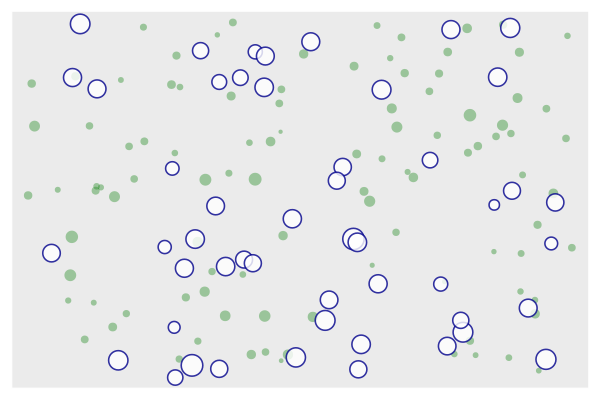

In [7]:
data = FacilityLocationData(50,100,50);
# green: customer, circle: facility
theme(:ggplot2)
scatter(
    data.customers[:, 1], 
    data.customers[:, 2],
    markersize = dropdims(mean(data.demand, dims=2), dims=2) / 3,
    mc = :forestgreen,
    msc = :forestgreen,
    markeralpha = 0.4,
    legend = :false,
    ticks = false,
    fmt = :png,
)
scatter!(
    data.facilities[:,1],
    data.facilities[:,2],
    markersize = log.(data.capacity)*2,
    mc = :white,
    msc = :darkblue,
    markeralpha = 0.8,
    msw = 2,
)


And now let's plot the facilities and customers!

## 2. Direct optimization

In [4]:
function direct_solve(
    data::FacilityLocationData,
    ; 
    verbose::Bool = true,
    time_limit::Int = 180,
    optimality_gap::Float64 = 1e-4,
)
    """Solve the optimization problem directly."""
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        model,
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap,
        "OutputFlag" => (verbose ? 1 : 0),
    )

    n = size(data.facilities, 1)
    m = size(data.customers, 1)
    S = size(data.demand, 2)
    @variable(model, x[1:n], Bin)
    @variable(model, y[1:m, 1:n, 1:S] ≥ 0)
    @variable(model, z[1:m, 1:S] ≥ 0)

    # Constraint (2): satisfy demand for each customer and each demand scenario
    @constraint(
        model, 
        [i in 1:m, s in 1:S],
        sum(y[i, j, s] for j = 1:n) + z[i, s] 
        ≥ data.demand[i, s]
    )
    # Constraint (3): produce under capacity of facilities, for each demand scenario
    @constraint(
        model, 
        [j in 1:n, s in 1:S],
        sum(y[i, j, s] for i = 1:m) 
        ≤ data.capacity[j] * x[j]
    )
    # Objective (1) # help duplication
    @expression(
        model, 
        fixed_cost,
        sum(data.facility_cost[j] * x[j] for j = 1:n) 
    )
    @expression(
        model, 
        transportation_cost,
        sum(data.prob[s] * data.transportation_cost[i, j] * y[i, j, s] for j = 1:n, i = 1:m, s = 1:S)
    )
    @expression(
        model, 
        unmet_demand_cost,
        sum(data.prob[s] * data.cost_unmet_demand[i] * z[i, s] for i = 1:m, s = 1:S)
    )
    @objective(
        model, 
        Min,
        fixed_cost + transportation_cost + unmet_demand_cost
    )

    solvetime = @elapsed optimize!(model)
    return Dict(
        "objective" => objective_value(model),
        "bound" => objective_bound(model),
        "solvetime" => solvetime,
        "facility" => value.(x),
        "transport" => value.(y),
        "unmet" => value.(z),
    )
end

direct_solve (generic function with 1 method)

In [44]:
# linear relaxation (C_j)
direct_solve(data, verbose=true)

Set parameter OutputFlag to value 1
Set parameter OutputFlag to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 7500 rows, 255050 columns and 507500 nonzeros
Model fingerprint: 0xf35d58c4
Variable types: 255000 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [6e-05, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-07, 4e+02]
Found heuristic solution: objective 13684.929258
Found heuristic solution: objective 13684.929228
Presolve removed 1 rows and 1501 columns
Presolve time: 0.98s
Presolved: 7499 rows, 253549 columns, 504499 nonzeros
Variable types: 253499 continuous, 50 integer (50 binary)

Root relaxation: objective 1.466737e+03, 13498 iterations, 0.35 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumb

Dict{String, Any} with 6 entries:
  "transport" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; …
  "solvetime" => 3.05014
  "objective" => 1467.27
  "unmet"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; …
  "bound"     => 1467.23
  "facility"  => [0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0  …  0.0, -0…

## 3. Benders decomposition

### 3.1. Multi-cut approach

We want to solve the problem using Benders decomposition. Consider the following multi-cut approach.

Main problem:
$$
\begin{align}
    \tag{MP}
    \min \quad 
    & \sum_{j=1}^n c_j x_j + \sum_{s=1}^S p_s \theta_s 
    \\
    \text{s.t.} \quad 
    & \mathbf{x} \in \{0,1\}^n, 
    \ \mathbf{\theta} \geq 0
\end{align}
$$
Subproblem $s$:
$$
\begin{align}
    \tag{SP($s$)}
    \min \quad 
    & \sum_{j=1}^n \sum_{i=1}^m t_{ij} y_{ij}^s 
    + \sum_{i=1}^m u_i z_{i}^s
    \\
    \text{s.t.} \quad 
    & \sum_{j=1}^n y_{ij}^s + z_i^s \geq d_i^s 
    && \forall \ i \in [m]
    \\
    & \sum_{i=1}^m y_{ij}^s \leq C_j x_j
    && \forall \ j \in [n]
    \\
    & \mathbf{y}, \mathbf{z} \geq 0
\end{align}
$$

Dual subproblem $s$:
$$
\begin{align}
    \tag{SPD($s$)}
    \max \quad 
    & \sum_{i=1}^m \mu_i^s d_i^s 
    - \sum_{j=1}^n \lambda_j^s C_j x_j
    \\
    \text{s.t.} \quad 
    & \mu_i^s - \lambda_j^s \leq t_{ij} 
    && \forall \ j \in [n], \ i \in [m]
    \\
    & \mu_i^s \leq q_i 
    && \forall \ i \in [m]
    \\
    & \mathbf{\mu}^s, \mathbf{\lambda}^s \geq 0
\end{align}
$$
- If the dual subproblem is unbounded, we obtain an extreme ray $(\mu^*, \lambda^*)$ and add a feasibility cut:
$$ 0 \geq \sum_{i=1}^m \mu^*_i d_i^s - \sum_{j=1}^n \lambda^*_j C_j x_j$$

- If the dual subproblem solves to optimality, we obtain an extreme point $(\mu^*, \lambda^*)$ and add an optimality cut:
$$θ_s \geq \sum_{i=1}^m \mu^*_i d_i^s - \sum_{j=1}^n \lambda^*_j C_j x_j$$

We can implement this decomposition as follows:

In [8]:
function solve_benders_multi(
    data::FacilityLocationData,
    ;
    verbose::Bool = false,
    time_limit::Int = 180,
    optimality_gap::Float64 = 1e-4,
)
    """Solve problem using multi-cut Benders decomposition."""
    
    # Define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV));
    set_optimizer_attributes(
        MP, 
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap, 
        "OutputFlag" => 0,
    )

    n = size(data.facilities, 1)
    m = size(data.customers, 1)
    S = size(data.demand, 2)
    @variable(MP, x[1:n], Bin)
    @variable(MP, θ[1:S] ≥ 0)
    @expression(
        MP, 
        fixed_cost,
        sum(data.facility_cost[i] * x[i] for i=1:n) 
    )
    # MP objective
    @objective(
        MP, 
        Min, 
        fixed_cost + sum(data.prob[s] * θ[s] for s in 1:S)
    )

    lower_bound_all = []
    upper_bound_all = []
    MP_time = []
    SP_time = []
    while true
        # Solve main problem
        push!(MP_time, @elapsed optimize!(MP))
        lower_bound_new = objective_value(MP)
        push!(lower_bound_all, lower_bound_new)
        x_MP = value.(MP[:x])

        # solve S subproblems
        obj_SP = zeros(S)
        SP_time_all = zeros(S)
        for s = 1:S
            SP_dual = Model(() -> Gurobi.Optimizer(GRB_ENV))
            @suppress set_optimizer_attributes(
                SP_dual, 
                "MIPGap" => optimality_gap, 
                "InfUnbdInfo" => 1, 
                "DualReductions" => 0, 
                "OutputFlag" => 0,
            )
            @variable(SP_dual, λ[1:n] ≥ 0)
            @variable(SP_dual, μ[1:m] ≥ 0)

            # SPD(s) objective
            @objective(
                SP_dual, 
                Max,
                sum(μ[i] * data.demand[i,s] for i in 1:m) 
                - sum(λ[j] * data.capacity[j] * x_MP[j] for j in 1:n)
            )
            # SPD(s) constraint 1
            @constraint(
                SP_dual, 
                [j in 1:n, i in 1:m], 
                μ[i] - λ[j] ≤ data.transportation_cost[i,j]
            )
            # SPD(s) constraint 2
            @constraint(
                SP_dual, 
                [i in 1:m], 
                μ[i] ≤ data.cost_unmet_demand[i]
            )
            SP_time_all[s] = @elapsed optimize!(SP_dual)
            obj_SP_dual = objective_value(SP_dual)
            λ_val = value.(SP_dual[:λ])
            μ_val = value.(SP_dual[:μ])
            
            # If dual subproblem is unbounded, add feasibility cut
            if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE
                @constraint(
                    MP, 
                    0 
                    ≥ sum(μ_val[i] * data.demand[i, s] for i in 1:m)
                    - sum(λ_val[j] * data.capacity[j] * x[j] for j in 1:n)
                )
                obj_SP[s] = Inf
            # If dual subproblem is bounded and solves to optimality, add optimality cut
            elseif termination_status(SP_dual) == MOI.OPTIMAL
                @constraint(
                    MP, 
                    θ[s] 
                    ≥ sum(μ_val[i] * data.demand[i, s] for i in 1:m)
                    - sum(λ_val[j] * data.capacity[j] * x[j] for j in 1:n)
                )
                obj_SP[s] = obj_SP_dual
            end
        end

        # Update solve time metrics, upper bound
        push!(SP_time, sum(SP_time_all))
        upper_bound_new = (
            sum(data.facility_cost[j] * x_MP[j] for j in 1:n) 
            + sum(data.prob[s] * obj_SP[s] for s in 1:S)
        )
        push!(upper_bound_all, upper_bound_new)

        if verbose
            @printf("Sol: %.2f - Bound: %.2f\n", upper_bound_all[end], lower_bound_all[end])
        end

        # Termination criteria
        if (
            sum(MP_time) + sum(SP_time) ≥ time_limit 
            || (upper_bound_new - lower_bound_new) / lower_bound_new < optimality_gap
        )
            break
        end
    end
    return upper_bound_all, lower_bound_all, MP_time, SP_time
end

solve_benders_multi (generic function with 1 method)

In [36]:
@time (
    upper_multi,
    lower_multi, 
    main_time_multi, 
    subproblem_time_multi, 
) = solve_benders_multi(data, verbose = true);

Sol: 13684.93 - Bound: 0.00
Sol: 1724.50 - Bound: 810.46
Sol: 1486.33 - Bound: 1239.39
Sol: 1480.71 - Bound: 1448.43
Sol: 1467.27 - Bound: 1454.43
Sol: 1482.13 - Bound: 1465.97
Sol: 1483.29 - Bound: 1466.62
Sol: 1467.27 - Bound: 1467.27
 11.860193 seconds (76.50 M allocations: 3.805 GiB, 6.91% gc time)


We can take a look at the convergence by iteration:

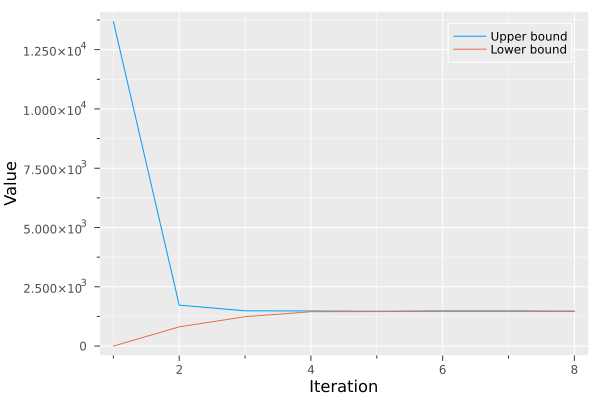

In [37]:
plot(
    [upper_multi lower_multi], 
    label = ["Upper bound" "Lower bound"], 
    xlabel = "Iteration",
    ylabel = "Value",
)

And we can also look at it as a function of time:

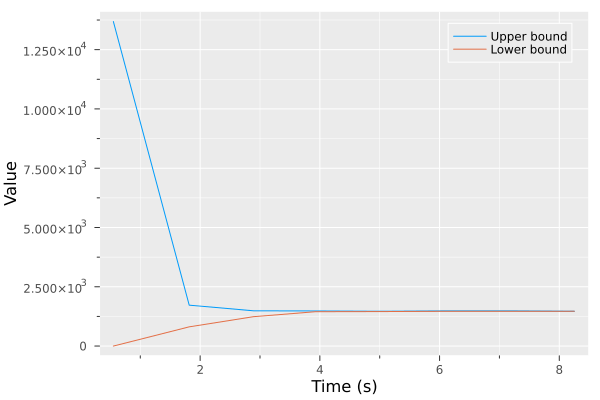

In [38]:
plot(
    cumsum(main_time_multi .+ subproblem_time_multi), 
    [upper_multi lower_multi], 
    label = ["Upper bound" "Lower bound"], 
    xlabel = "Time (s)",
    ylabel = "Value",
)

### 3.1.2 Multi-cut approach: parallel implementation

In [10]:
struct Cuts1
    x_coeff::Vector{Float64}
    θ_coeff::Float64
    intercept::Float64
end

In [11]:
function solve_benders_parallel(
    data::FacilityLocationData,
    ;
    verbose::Bool = false,
    time_limit::Int = 180,
    optimality_gap::Float64 = 1e-4,
)
    
    # Define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        MP, 
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap,
        "OutputFlag" => 0,
    )
    n = size(data.facilities, 1)
    m = size(data.customers, 1)
    S = size(data.demand, 2)
    @variable(MP, x[1:n], Bin)
    @variable(MP, θ[1:S] ≥ 0)
    @expression(
        MP, 
        fixed_cost,
        sum(data.facility_cost[i] * x[i] for i=1:n) 
    )
    @objective(
        MP, 
        Min, 
        fixed_cost + sum(data.prob[s] * θ[s] for s in 1:S)
    )

    lower_bound_all = []
    upper_bound_all = []
    MP_time = []
    SP_time = []
    # Initialize dual problems 
    SP_dual = [Model(() -> Gurobi.Optimizer(GRB_ENV)) for t = 1:Threads.nthreads()]
    for t = 1:Threads.nthreads()
        set_optimizer_attributes(
            SP_dual[t], 
            "MIPGap" => optimality_gap, 
            "InfUnbdInfo" => 1, 
            "DualReductions" => 0, 
            "OutputFlag" => 0,
        )
        @variable(SP_dual[t], λ[1:n] ≥ 0)
        @variable(SP_dual[t], μ[1:m] ≥ 0)
        @objective(SP_dual[t], Max, 0)  
        @constraint(
            SP_dual[t], 
            [j in 1:n, i in 1:m], 
            μ[i] - λ[j] <= data.transportation_cost[i,j])
        @constraint(
            SP_dual[t], 
            [i in 1:m], 
            μ[i] <= data.cost_unmet_demand[i]
        )
    end

    while true
        # Solve main problem
        push!(MP_time, @elapsed optimize!(MP))
        lower_bound_new = objective_value(MP)
        push!(lower_bound_all, lower_bound_new)
        x_MP = value.(MP[:x])
        
        # solve S subproblems -- multithreaded
        obj_SP = zeros(S)
        cuts_ac = Array{Cuts1}(undef, S)

        function solve_subproblem()
            Threads.@threads for s = 1:S
                set_objective_coefficient.(
                    SP_dual[Threads.threadid()], 
                    SP_dual[Threads.threadid()][:λ],
                    - data.capacity[:] .* x_MP[:]
                )
                set_objective_coefficient.(
                    SP_dual[Threads.threadid()], 
                    SP_dual[Threads.threadid()][:μ],
                    data.demand[:,s]
                )
                optimize!(SP_dual[Threads.threadid()])

                obj_SP_dual = objective_value(SP_dual[Threads.threadid()])
                λ_val = value.(SP_dual[Threads.threadid()][:λ])
                μ_val = value.(SP_dual[Threads.threadid()][:μ])        

                # If dual subproblem is unbounded, add feasibility cut
                if termination_status(SP_dual[Threads.threadid()]) == MOI.DUAL_INFEASIBLE
                    cuts_ac[s] = Cuts1(
                        λ_val .* data.capacity, 
                        0, 
                        - sum(μ_val[i] * data.demand[i, s] for i in 1:m)
                    )
                    obj_SP[s] = Inf
                # If dual subproblem is bounded and solves to optimality, add optimality cut
                elseif termination_status(SP_dual[Threads.threadid()]) == MOI.OPTIMAL
                    cuts_ac[s] = Cuts1(
                        λ_val .* data.capacity, 
                        1, 
                        - sum(μ_val[i] * data.demand[i, s] for i in 1:m)
                    )
                    obj_SP[s] = obj_SP_dual
                end
            end 
        end

        SP_time_all = @elapsed solve_subproblem()

        for s = 1:S
            cut = cuts_ac[s]
            @constraint(
                MP, 
                cut.x_coeff' * x 
                + θ[s] * cut.θ_coeff 
                + cut.intercept 
                ≥ 0
            )
        end
        
        # Update solve time metrics, upper bound
        push!(SP_time, SP_time_all)
        upper_bound_new = (
            sum(data.facility_cost[j] * x_MP[j] for j in 1:n) 
            + sum(data.prob[s] * obj_SP[s] for s in 1:S)
        )
        push!(upper_bound_all, upper_bound_new)

        if verbose
            @printf("Sol: %.2f - Bound: %.2f\n", upper_bound_all[end], lower_bound_all[end])
        end

        # Termination criteria
        if sum(MP_time) + sum(SP_time) ≥ time_limit 
            break
        end
        if lower_bound_new > 0
            if (upper_bound_new - lower_bound_new) / lower_bound_new < optimality_gap
                break
            end
        end       
    end
    
    return upper_bound_all, lower_bound_all, MP_time, SP_time
    
end

solve_benders_parallel (generic function with 1 method)

In [32]:
@time (
    upper_multi_parallel, 
    lower_multi_parallel,
    main_time_multi_parallel, 
    subproblem_time_multi_parallel,
) = solve_benders_parallel(data, verbose = true);

Sol: 13684.93 - Bound: 0.00
Sol: 1724.50 - Bound: 810.46
Sol: 1486.33 - Bound: 1239.39
Sol: 1480.71 - Bound: 1448.43
Sol: 1467.27 - Bound: 1454.43
Sol: 1482.13 - Bound: 1465.97
Sol: 1483.29 - Bound: 1466.62
Sol: 1467.27 - Bound: 1467.27
  3.184124 seconds (1.27 M allocations: 36.255 MiB, 1.11% gc time)


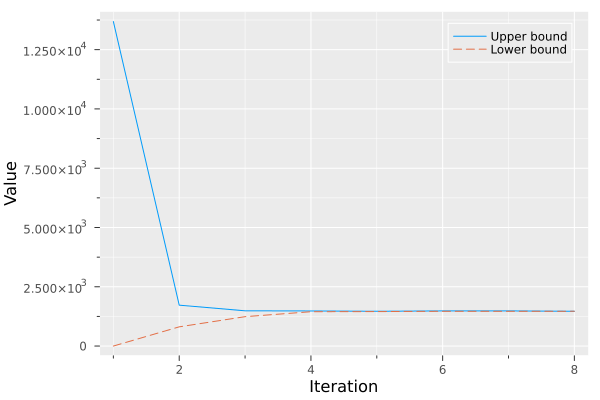

In [33]:
plot(
    [upper_multi_parallel lower_multi_parallel], 
    label = ["Upper bound" "Lower bound"], 
    linestyle = [:solid :dash],
    xlabel = "Iteration",
    ylabel = "Value",
)

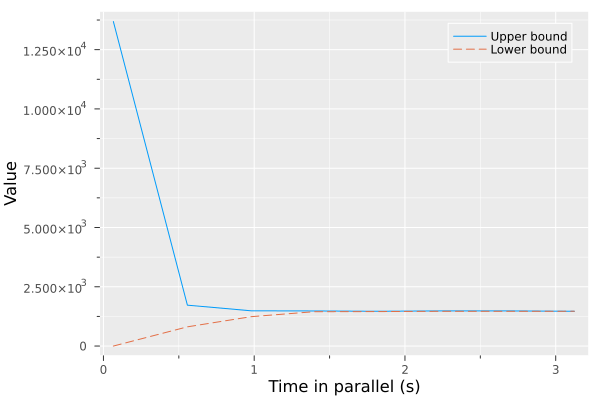

In [34]:
plot(
    cumsum(main_time_multi_parallel .+ subproblem_time_multi_parallel),
    [upper_multi_parallel lower_multi_parallel], 
    label = ["Upper bound" "Lower bound"], 
    linestyle = [:solid :dash],
    xlabel="Time in parallel (s)",
    ylabel = "Value",
)

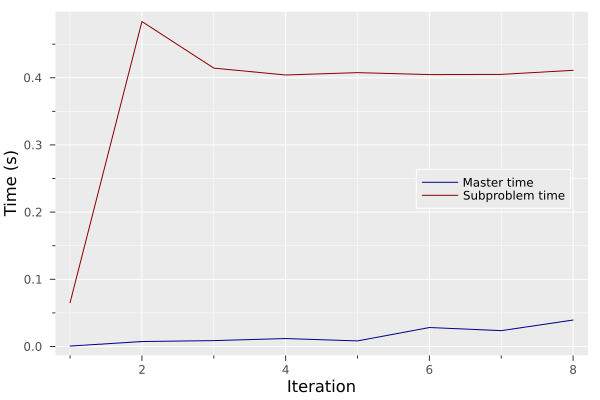

In [35]:
plot(
    [main_time_multi_parallel subproblem_time_multi_parallel], 
    label = ["Master time" "Subproblem time"], 
    color = [:darkblue :darkred],
    xlabel = "Iteration", 
    ylabel = "Time (s)", 
    legend = :right,
)

### 3.2. Single-cut approach

An alternative approach is the following formulation:

\begin{align}
    \tag{MP-S}
    \min \quad 
    & \sum_{j=1}^n c_j x_j + \theta
    \\
    \text{s.t.} \quad 
    & \mathbf{x} \in \{0,1\}^n, 
    \ \mathbf{\theta} \geq 0
\end{align}

We keep the same $S$ subproblems, but this time we add cuts as follows:

- If **any** dual subproblem is unbounded, we obtain an extreme ray $(\mu^*, \lambda^*)$ and add a feasibility cut:
$$0 \geq \sum_{i=1}^m \mu^*_i d_i^s - \sum_{j=1}^n \lambda^*_j C_j x_j$$

- If **all** dual subproblems solve to optimality, we obtain extreme points $(\mu^*_s, \lambda^*_s)$ and add an optimality cut:
$$θ \geq \sum_{s=1}^S p_s \left(\sum_{i=1}^m \mu^*_{i} d_i^s - \sum_{j=1}^n\lambda^*_{j} C_j x_j\right)$$

In [16]:
function solve_benders_single(
    data::FacilityLocationData,
    ;
    verbose::Bool = false,
    time_limit::Int = 180,
    optimality_gap::Float64 = 1e-4,
)
    """Solve problem using single-cut Benders decomposition."""
    
    # Define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        MP, 
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap, 
        "OutputFlag" => 0,
    )
    
    n = size(data.facilities, 1)
    m = size(data.customers, 1)
    S = size(data.demand, 2)
    @variable(MP, x[1:n], Bin)
    @variable(MP, θ ≥ 0)
    @expression(
        MP, 
        fixed_cost,
        sum(data.facility_cost[j] * x[j] for j in 1:n) 
    )
    # MP objective
    @objective(
        MP, 
        Min, 
        fixed_cost + θ
    )

    lower_bound_all = []
    upper_bound_all = []
    MP_time = []
    SP_time = []

    # Set up subproblem
    SP_dual = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        SP_dual, 
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap, 
        "OutputFlag" => 0,
        "InfUnbdInfo" => 1, 
        "DualReductions" => 0,
    )
    @variable(SP_dual, λ[1:n] ≥ 0)
    @variable(SP_dual, μ[1:m] ≥ 0)
    @objective(SP_dual, Max, 0)
    @constraint(
        SP_dual, 
        [j in 1:n, i in 1:m], 
        μ[i] - λ[j] ≤ data.transportation_cost[i, j]
    )
    @constraint(
        SP_dual, 
        [i in 1:m], 
        μ[i] ≤ data.cost_unmet_demand[i]
    )

    it = 0
    while true
        it += 1

        # Solve main problem
        push!(MP_time, @elapsed optimize!(MP))
        lower_bound_new = objective_value(MP)
        push!(lower_bound_all, lower_bound_new)
        x_MP = value.(MP[:x])

        # set up subproblem loop
        obj_SP = zeros(S)
        SP_time_all = zeros(S)
        λ_all = zeros(n, S)
        μ_all = zeros(m, S)
        optimality_cut = true
        for s in 1:S
            set_objective_coefficient.(
                SP_dual, 
                SP_dual[:λ], 
                - data.capacity[:] .* x_MP[:]
            )
            set_objective_coefficient.(
                SP_dual, 
                SP_dual[:μ], 
                data.demand[:,s]
            )

            SP_time_all[s] = @elapsed optimize!(SP_dual)
            obj_SP_dual = objective_value(SP_dual)
            λ_all[:, s] = value.(SP_dual[:λ])
            μ_all[:, s] = value.(SP_dual[:μ])
            
            # If dual subproblem is unbounded, add feasibility cut
            if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE
                optimality_cut = false
                @constraint(
                    MP, 
                    0 
                    ≥ sum(μ_all[i, s] * data.demand[i, s] for i in 1:m) 
                    - sum(λ_all[j, s] * data.capacity[j] * x[j] for j in 1:n)
                )
                obj_SP[s] = Inf
            elseif termination_status(SP_dual) == MOI.OPTIMAL
                obj_SP[s] = obj_SP_dual
            end
        end
        if optimality_cut
            @constraint(
                MP, 
                θ ≥ sum(
                    data.prob[s] * (
                        sum(μ_all[i, s] * data.demand[i, s] for i in 1:m)
                        - sum(λ_all[j, s] * data.capacity[j] * x[j] for j in 1:n) 
                    ) for s = 1:S
                )
            )
        end
        
        # Update solve time metrics, upper bound
        push!(SP_time, sum(SP_time_all))
        upper_bound_new = (
            sum(data.facility_cost[j] * x_MP[j] for j in 1:n) 
            + sum(data.prob[s] * obj_SP[s] for s in 1:S)
        )
        push!(upper_bound_all, upper_bound_new)

        if verbose
            @printf("Sol: %.2f - Bound: %.2f\n", upper_bound_all[end], lower_bound_all[end])
        end

        # Termination criteria
        if (
            sum(MP_time) + sum(SP_time) ≥ time_limit 
            || (upper_bound_new - lower_bound_new) / lower_bound_new < optimality_gap
        )
            break
        end
    end
    return upper_bound_all, lower_bound_all, MP_time, SP_time
end

solve_benders_single (generic function with 1 method)

Let's try this on our problem:

In [30]:
@time (
    upper_single,
    lower_single, 
    main_time_single, 
    subproblem_time_single, 
) = solve_benders_single(data, verbose = true);

Sol: 13684.93 - Bound: 0.00
Sol: 4475.95 - Bound: 333.41
Sol: 2055.59 - Bound: 646.96
Sol: 1519.54 - Bound: 976.02
Sol: 1509.84 - Bound: 1307.31
Sol: 1489.73 - Bound: 1416.64
Sol: 1467.27 - Bound: 1431.19
Sol: 1486.33 - Bound: 1460.39
Sol: 1482.13 - Bound: 1464.41
Sol: 1480.71 - Bound: 1465.57
Sol: 1467.27 - Bound: 1467.27
  4.223868 seconds (1.61 M allocations: 40.150 MiB)


And we can plot the progress, as before...

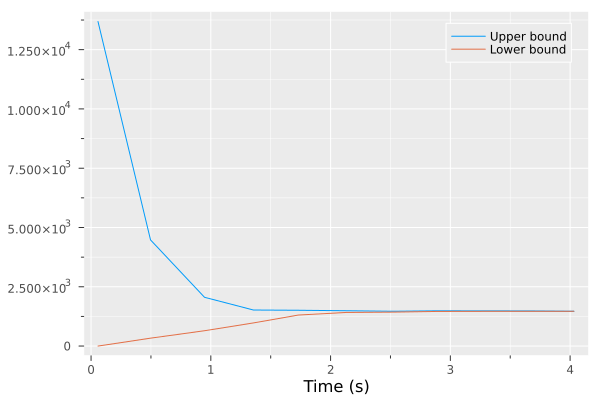

In [31]:
plot(
    cumsum(main_time_single .+ subproblem_time_single), 
    [upper_single lower_single], 
    label = ["Upper bound" "Lower bound"], 
    xlabel = "Time (s)",
)

### 3.3 Pareto-optimal cuts

In lecture, we also discussed Pareto-optimal cuts, i.e. cuts that provide a tighter approximation to the recourse function. We mentioned that we can compute a Pareto-optimal cut by finding the best cut for a particular "core point" $x^0$. We first solve the dual subproblem:

\begin{align}
    \tag{SPD($s$)}
    z^* = \max \quad 
    & \sum_{i=1}^m \mu_i d_i^s 
    - \sum_{j=1}^n \lambda_j C_j x_j
    \\
    \text{s.t.} \quad 
    & \mu_i - \lambda_j \leq t_{ij} 
    && \forall \ j \in [n], \ i \in [m]
    \\
    & \mu_i \leq u_i
    && \forall \ i \in [m]
    \\
    & \mathbf{\mu}, \mathbf{\lambda} \geq 0
\end{align}

The, given the optimal objective, $z^*$, we solve the problem again with a new objective, i.e.

\begin{align}
    \tag{SPDP($s$)}
    \max \quad 
    & \sum_{i=1}^m \mu_i d_i^s 
    - \sum_{j=1}^n \lambda_j C_j x^0_j
    \\
    \text{s.t.} \quad 
    & \mu_i - \lambda_j \leq t_{ij} 
    && \forall \ j \in[n], \ i \in [m]
    \\
    & \mu_i \leq u_i
    && \forall \ i \in [m]
    \\
    & \sum_{i=1}^m \mu_i d_i^s 
    - \sum_{j=1}^n \lambda_j C_j x_j = z^*
    \\
    & \mathbf{\mu}, \mathbf{\lambda} \geq 0
\end{align}

The core point we use is $x^0=\{0.5\}_{j=1}^n$.

In [28]:
function solve_benders_pareto(
    data::FacilityLocationData,
    ;
    verbose::Bool = false,
    time_limit::Int = 180,
    optimality_gap::Float64 = 1e-4,
)
    """Solve problem using single-cut Benders decomposition with Pareto-optimal cuts."""

    # Define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        MP, 
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap, 
        "OutputFlag" => 0,
    )

    n = size(data.facilities, 1)
    m = size(data.customers, 1)
    S = size(data.demand, 2)
    @variable(MP, x[1:n], Bin)
    @variable(MP, θ ≥ 0)
    @expression(
        MP, 
        fixed_cost,
        sum(data.facility_cost[j] * x[j] for j in 1:n) 
    )
    # MP objective
    @objective(
        MP, 
        Min, 
        fixed_cost + θ
    )

    lower_bound_all = []
    upper_bound_all = []
    MP_time = []
    SP_time = []
    SP_max_time = []
    while true
        # Solve main problem
        push!(MP_time, @elapsed optimize!(MP))
        lower_bound_new = objective_value(MP)
        push!(lower_bound_all, lower_bound_new)
        x_MP = value.(MP[:x])

        # set up subproblem loop
        obj_SP = zeros(S)
        SP_time_all = zeros(S)
        λ_all = zeros(n, S)
        μ_all = zeros(m, S)
        optimality_cut = true
        for s in 1:S
            SP_dual = Model(() -> Gurobi.Optimizer(GRB_ENV))
            set_optimizer_attributes(SP_dual, "OutputFlag" => 0)
            @variable(SP_dual, λ[1:n] ≥ 0)
            @variable(SP_dual, μ[1:m] ≥ 0)

            # SPD(s) objective
            @objective(
                SP_dual, 
                Max, 
                sum(μ[i] * data.demand[i,s] for i in 1:m)
                - sum(λ[j] * data.capacity[j] * x_MP[j] for j in 1:n)
            )
            # SPD(s) constraint 1
            @constraint(
                SP_dual, 
                [j in 1:n, i in 1:m], 
                μ[i] - λ[j] ≤ data.transportation_cost[i, j]
            )
            # SPD(s) constraint 2
            @constraint(
                SP_dual, 
                [i in 1:m], 
                μ[i] ≤ data.cost_unmet_demand[i]
            )
            SP_time_all[s] = @elapsed optimize!(SP_dual)
            obj_SP_dual = objective_value(SP_dual)
            λ_all[:, s] = value.(SP_dual[:λ])
            μ_all[:, s] = value.(SP_dual[:μ])

            # If dual subproblem is unbounded, add feasibility cut
            if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE # feasibility cut
                optimality_cut = false
                @constraint(
                    MP, 
                    sum(μ_all[i, s] * data.demand[i, s] for i in 1:m) 
                    - sum(λ_all[j, s] * data.capacity[j] * x[j] for j in 1:n) 
                    ≤ 0
                )
                obj_SP[s] = Inf
            # If dual subproblem is bounded and solves to optimality, 
            # solve SPDP(s) with the previous objective value found to get a cut at the core point
            elseif termination_status(SP_dual) == MOI.OPTIMAL
                obj_SP[s] = obj_SP_dual
                @constraint(
                    SP_dual, 
                    sum(μ[i] * data.demand[i,s] for i in 1:m)
                    - sum(λ[j] * data.capacity[j] * x_MP[j] for j in 1:n) == obj_SP[s]
                )
                @objective(
                    SP_dual, 
                    Max, sum(μ[i] * data.demand[i,s] for i in 1:m)
                    - sum(λ[j] * data.capacity[j] * 0.5 for j in 1:n)
                )
                SP_time_all[s] += @elapsed optimize!(SP_dual)
                λ_all[:, s] = value.(SP_dual[:λ])
                μ_all[:, s] = value.(SP_dual[:μ])
            end
        end
        if optimality_cut
            @constraint(
                MP, 
                θ ≥ sum(
                    data.prob[s] * (
                        sum(μ_all[i, s] * data.demand[i, s] for i = 1:m)
                        - sum(λ_all[j, s] * data.capacity[j] * x[j] for j = 1:n) 
                    ) for s = 1:S
                )
            )
        end

        # Update solve time metrics, upper bound
        push!(SP_max_time, maximum(SP_time_all))
        push!(SP_time, sum(SP_time_all))
        upper_bound_new = (
            sum(data.facility_cost[j] * x_MP[j] for j in 1:n) 
            + sum(data.prob[s] * obj_SP[s] for s in 1:S)
        )
        push!(upper_bound_all, upper_bound_new)
        
        if verbose
            @printf("Sol: %.2f - Bound: %.2f\n", upper_bound_all[end], lower_bound_all[end])
        end

        # Termination criteria
        if (
            sum(MP_time) + sum(SP_time) ≥ time_limit 
            || (upper_bound_new - lower_bound_new) / lower_bound_new < optimality_gap
        )
            break
        end
    end
    return upper_bound_all, lower_bound_all, MP_time, SP_time, SP_max_time
end

solve_benders_pareto (generic function with 1 method)

Let's solve the problem using Pareto cuts:

In [39]:
@time (
    upper_pareto,
    lower_pareto, 
    main_time_pareto, 
    subproblem_time_pareto, 
    subproblem_max_time_pareto,
) = solve_benders_pareto(data, verbose = true);

Sol: 13684.93 - Bound: 0.00
Sol: 4475.95 - Bound: 333.41
Sol: 2055.59 - Bound: 646.96
Sol: 1519.54 - Bound: 976.02
Sol: 1509.84 - Bound: 1307.31
Sol: 1489.73 - Bound: 1416.83
Sol: 1467.27 - Bound: 1431.19
Sol: 1486.33 - Bound: 1460.39
Sol: 1482.13 - Bound: 1464.41
Sol: 1480.71 - Bound: 1465.57
Sol: 1467.27 - Bound: 1467.27
 15.990778 seconds (107.12 M allocations: 5.282 GiB, 7.69% gc time)


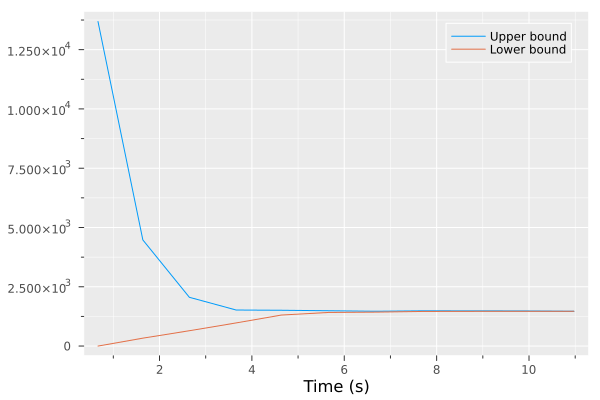

In [40]:
plot(
    cumsum(main_time_pareto .+ subproblem_time_pareto), 
    [upper_pareto lower_pareto], 
    label = ["Upper bound" "Lower bound"], 
    xlabel = "Time (s)",
)

Instead of solving the dual subproblem twice, another way to obtain Pareto-optimal cuts is to add the core point objective with a small weight $\varepsilon$, to the original dual objective.

### 3.4 Benders cuts with lazy constraints

The main drawback of the approaches above is that we have to restart solving the master problem from scratch every time we add the cuts. One way we can change that is by using lazy constraints.

Instead of providing the solver with constraints, we give it a "callback function", i.e., a function which takes in a solution and provides a constraint that it violates. The solver will regularly call this function to see if there are new constraints that need to be added.

In [26]:
function solve_benders_lazy(
    data::FacilityLocationData,
    ;
    verbose::Int = 0,
    time_limit::Int = 180,
    optimality_gap::Float64 = 1e-4,
)
    """Solve problem using multi-cut Benders decomposition with lazy cuts 
    - verbose can be 0, 1 or 2"""

    # define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        MP, 
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap, 
        "OutputFlag" => (verbose > 0 ? 1 : 0), 
        "LazyConstraints" => 1,
    )

    n = size(data.facilities, 1)
    m = size(data.customers, 1)
    S = size(data.demand, 2)
    @variable(MP, x[1:n], Bin)
    @variable(MP, θ ≥ 0)
    @expression(
        MP, 
        fixed_cost,
        sum(data.facility_cost[j] * x[j] for j in 1:n) 
    )
    # MP objective
    @objective(
        MP, 
        Min, 
        fixed_cost + θ
    )

    # Define the callback function
    function add_benders_cuts(cb_data)
        status = callback_node_status(cb_data, MP)
        if status == MOI.CALLBACK_NODE_STATUS_INTEGER
            if verbose == 2 
                println("Adding lazy constraints...")
            end

            # get value of current solution
            x_MP = [round(callback_value(cb_data, x[j])) for j in 1:n]
            λ_all = zeros(n, S)
            μ_all = zeros(m, S)
            optimality_cut = true

            # solve dual subproblems
            for s = 1:S
                SP_dual = Model(() -> Gurobi.Optimizer(GRB_ENV))
                set_optimizer_attributes(SP_dual, "OutputFlag" => 0)
                @variable(SP_dual, λ[1:n] ≥ 0)
                @variable(SP_dual, μ[1:m] ≥ 0)
                @objective(
                    SP_dual, 
                    Max,
                    sum(μ[i] * data.demand[i, s] for i in 1:m) 
                    - sum(λ[j] * data.capacity[j] * x_MP[j] for j in 1:n)
                )
                @constraint(
                    SP_dual, 
                    [j in 1:n, i in 1:m], 
                    μ[i] - λ[j] ≤ data.transportation_cost[i,j]
                )
                @constraint(
                    SP_dual, 
                    [i in 1:m], 
                    μ[i] ≤ data.cost_unmet_demand[i]
                )

                optimize!(SP_dual)
                λ_all[:,s] = value.(SP_dual[:λ])
                μ_all[:,s] = value.(SP_dual[:μ])

                # If dual subproblem is unbounded, add feasibility cut
                if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE
                    optimality_cut = false
                    fea = @build_constraint(
                        sum(μ_all[i, s] * data.demand[i, s] for i in 1:m) 
                        - sum(λ_all[j, s] * data.capacity[j] * x[j] for j in 1:n) 
                        ≤ 0
                    )
                    MOI.submit(MP, MOI.LazyConstraint(cb_data), fea)
                elseif termination_status(SP_dual) == MOI.OPTIMAL
                    nothing
                end
            end
            opt = @build_constraint(
                θ ≥ sum(
                    data.prob[s] * (
                        sum(μ_all[i, s] * data.demand[i,s] for i in 1:m) 
                        - sum(λ_all[j, s] * data.capacity[j] * x[j] for j in 1:n)
                    )
                    for s in 1:S
                )
            )
            MOI.submit(MP, MOI.LazyConstraint(cb_data), opt)
        end
    end

    # set callback function and attach to model
    MOI.set(MP, MOI.LazyConstraintCallback(), add_benders_cuts)
    solvetime = @elapsed optimize!(MP)
    opt = objective_value(MP)
    bound = objective_bound(MP)
    return opt, bound, solvetime
end

solve_benders_lazy (generic function with 1 method)

We can solve the problem using lazy constraints:

In [41]:
solve_benders_lazy(data, verbose = 0)

(1467.2711185358037, 1467.2711185358037, 23.1417205)

In [42]:
solve_benders_lazy(data, verbose = 1)

Set parameter OutputFlag to value 1
Set parameter LazyConstraints to value 1
Set parameter OutputFlag to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 0 rows, 51 columns and 0 nonzeros
Model fingerprint: 0x16d53465
Variable types: 1 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 51 columns, 0 nonzeros
Variable types: 1 continuous, 50 integer (50 binary)

Root relaxation: objective 3.304553e+02, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  330.45526    0    1          -  330.45526      -     -    4s
H    0     0             

(1467.2711185358037, 1467.2711185358037, 23.4403996)

In [43]:
solve_benders_lazy(data, verbose = 2)

Set parameter OutputFlag to value 1
Set parameter LazyConstraints to value 1
Set parameter OutputFlag to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 0 rows, 51 columns and 0 nonzeros
Model fingerprint: 0x16d53465
Variable types: 1 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Adding lazy constraints...
Adding lazy constraints...
Adding lazy constraints...
Adding lazy constraints...
Adding lazy constraints...
Presolve time: 0.00s
Presolved: 0 rows, 51 columns, 0 nonzeros
Variable types: 1 continuous, 50 integer (50 binary)
Adding lazy constraints...

Root relaxation: objective 3.304553e+02, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

(1467.2711185358037, 1467.2711185358037, 22.6404657)

Note that here we are using JuMP's solver-independent solver callback syntax. That means we don't have as much control about what to do within the callback, and when to actually call it. For example, when we set `verbose=2` above, we see we generate a lot of lazy constraints even before the end of the presolve. Why might that happen?

If we want more fine-grained control over the solver, we can write a solver-dependent callback function, using the `Gurobi.jl` package directly - see [here](https://www.gurobi.com/documentation/10.0/refman/cb_codes.html) for more details!

Another drawback of using lazy constraints is that it is harder to parallelize, and we do not have full control over when the callback is run. There are many examples where using lazy constraints considerably speeds up the problem. A usual one is the traveling salesman problem, and related vehicle routing problems.